## part 7 Analyzing MCMC chains

Created: 10/30/2017 (cloned from part2_analysis_hatp12_rerun.ipynb)

1. fit each light curve with a chi-square minimizing method,
2. rescale the error bars so that the reduced chi-square becomes unity
   (i.e., multiply the errors by sqrt(chi-square/dof)),
3. re-rescale them by a factor of “beta” to take into account red noises.

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
from tqdm import tqdm

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [4]:
dirname='../HAT-P-44b/'
name               = 'hatp44'
date               = '170215'
target_star_id     = '2'
comparison_star_id = '1'
radii_range        = '9-14'
b                  = 'g'

data={}
data2={} #df for outliers removed
sigma=5.0

bands='g,r,z'.split(',')
for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    path=os.path.join(dirname,fname)
    df=pd.read_csv(path, delimiter=' ', parse_dates=True)
    #remove columns
    df=df.drop(['Unnamed: 20','frame'],axis=1)
    #set index
    df=df.set_index('BJD(TDB)-2450000')
    data[b]=df
    #remove outliers
    df2 = df[np.abs(df-df.mean())<=(sigma*df.std())]
    data2[b]=df2

In [5]:
fluxes=[]
ts    =[]
fluxcol= 'flux(r=11.0)'

for b in sorted(bands):
    fluxes.append(data2[b][fluxcol])
    ts.append(data2[b].index)

## building the model

* See [exoplanet.org](http://exoplanets.org/detail/HAT-P-12_b) for published transit parameters

In [6]:
from uncertainties import ufloat 

P   = ufloat(3.2130598,2.1e-6)
Rp  = ufloat(0.959,0.029)
Rs  = ufloat(0.701,0.017) #+0.017/-0.012
#tc  = ufloat(2454400.19885, 0.0002) 
t14 = ufloat(0.09740,0.0006) 
b   = ufloat(0.211,0.07)     
a_s = ufloat(11.80,0.31)   
k   = ufloat(np.sqrt(0.01977),np.sqrt(0.000183)) 
rhop= ufloat(0.295,0.025)
inc = ufloat(89.00,0.4)

tc_0  = 2.457873e6+0.23
q1_0, q2_0 = 0.4, 0.4

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [7]:
_P   = 3.2130598
#_tc  = 245778e6+8.01
_t14 = 0.09740
_b   = 0.211
_a_s = 11.80
_k   = np.sqrt(0.01977)
_inc = np.deg2rad(89.00)



def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

a_s_=scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

11.789821867071863

In [8]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=4650,60, 4.610,0.01, -0.290,0.05

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

In [9]:
from pytransit import MandelAgol
MA = MandelAgol()

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    MA = MandelAgol()
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = np.arccos(b/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

In [10]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, aux_vec, ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[7:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

In [11]:
from scipy import stats
def logprior(theta,up=None):
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > 1 or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a   < 0 or a  > 100 or \
        tc < t[0] or tc > t[-1]:
            
        #print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,airmasses,dxs,dys,up=None):
    '''
    logprob = log likelihood + log prior
    '''
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,impact_param,q12,q22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,impact_param,q13,q23,ls3,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, aux_vec1)
    ll += loglike(theta2, t2, f2, p, aux_vec2)
    ll += loglike(theta3, t3, f3, p, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

## MCMC result

In [12]:
loc = 'sample_chain'

#after burn-in
import gzip

with gzip.GzipFile(os.path.join(loc,'chain2_hatp12.npy.gz'), "r") as g:
    chain2=np.load(g)
nwalkers,nsteps,ndim=chain2.shape
nwalkers,nsteps,ndim

(256, 10000, 32)

In [13]:
#remove burnin
burn=9000
fc = chain2[:,burn:,:].reshape([-1,chain2.shape[-1]])
fc.shape

(256000, 32)

In [14]:
#load
import gzip
import numpy as np

with gzip.GzipFile(os.path.join(loc,'lnp2_hatp12.npy.gz'), "r") as g:
    lnp2=np.load(g)
lnp2.shape

(2560000,)

In [15]:
lnp2=lnp2[nwalkers*burn:]
lnp2.shape

(256000,)

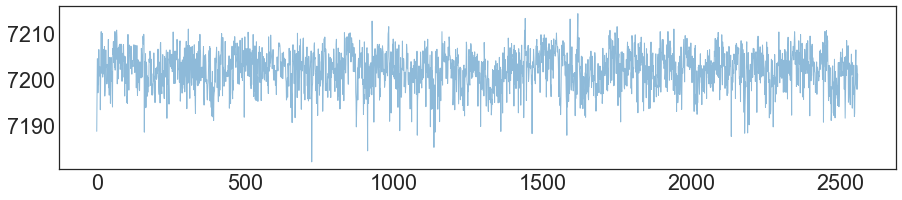

In [16]:
thin=100

fig=pl.figure(figsize=(15,3))
pl.plot(lnp2[::thin], lw=1, alpha=0.5)

## Comparison to published values

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

## Results

In [17]:
param_names='k1,k2,k3,tc,a1,a2,a3,b,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

#using full chain excluding burn-in
max_idx=np.argmax(lnp2)

#posterior of parameter vector
pv=fc[max_idx]

for n, i in zip(param_names, pv): 
    print('{0}:\t{1:.4f}'.format(n,i))

k1:	0.1439
k2:	0.1409
k3:	0.1363
tc:	2457873.2293
a1:	12.1157
a2:	11.8946
a3:	11.8677
b:	0.1769
q11:	0.3060
q12:	0.2681
q13:	0.2087
q21:	0.7918
q22:	0.8359
q23:	0.5617
ls1:	-6.3137
ls2:	-6.2778
ls3:	-6.1282
k01:	0.0235
k02:	0.0048
k03:	-0.0031
k11:	0.0007
k12:	0.0005
k13:	0.0012
k21:	0.0004
k22:	0.0002
k23:	-0.0008
k31:	40561.9080
k32:	15154.7322
k33:	-49872.1332
k41:	-0.0165
k42:	-0.0062
k43:	0.0203


In [19]:
np.save('theta_post.csv', pv)

## best fit with uncertainties: credible intervals

1. fit each light curve with a chi-square minimizing method,
2. rescale the error bars so that the reduced chi-square becomes unity
   (i.e., multiply the errors by sqrt(chi-square/dof)),
3. re-rescale them by a factor of “beta” to take into account red noises.

In [58]:
def chi2(theta, p, t, f):
    '''
    reduced chi-quared
    '''
    ls=theta[6]
    sigma=np.exp(ls)
    m = model_q(theta[:6], t, p)
    
    return np.sum((m-f)**2/sigma**2)

In [61]:
q_g=pv[8:14:3]
q_r=pv[9:14:3]
q_z=pv[10:14:3]
tc=pv[3]
b =pv[7]

ndim=32
n=0

print('band\tchi^2\tred. chi^2')
for k,a,q,ls,t,f in zip(pv[:3],pv[4:7], [q_g,q_r,q_z], pv[14:17], ts, fluxes):
    q1,q2=q
    theta=k,tc,a,b,q1,q2,ls
    res=chi2(theta, _P, t, f)
    dof=len(t)-ndim
    rcs = np.sqrt(res/dof)
    print('{}:\t{:.1f}\t{:.1f}'.format(bands[n], res, rcs))
    n+=1

band	chi^2	red. chi^2
g:	16765.2	7.0
r:	27103.9	6.4
z:	9091.0	5.1


In [79]:
post=[]
for i,(j,p) in enumerate(zip(pv,param_names)):
    fc_sample=fc[np.random.randint(0, fc.shape[0], size=1000)]
    sig_minus,mean,sig_plus=np.percentile(fc_sample[:,i], [16,50,84], axis=0)
    vals='{0}={1:.4f}\t- {2:.4f} \t+ {2:.4f}'.format(p,j,sig_minus,sig_plus)
    post.append(vals)
    print(vals)
    #print(mean)
np.save('post_with_unc_hapt12b.csv',post)

k1=0.1439	- 0.1393 	+ 0.1393
k2=0.1409	- 0.1388 	+ 0.1388
k3=0.1363	- 0.1362 	+ 0.1362
tc=2457873.2293	- 2457873.2291 	+ 2457873.2291
a1=12.1157	- 11.6672 	+ 11.6672
a2=11.8946	- 11.5617 	+ 11.5617
a3=11.8677	- 11.3931 	+ 11.3931
b=0.1769	- 0.0604 	+ 0.0604
q11=0.3060	- 0.3064 	+ 0.3064
q12=0.2681	- 0.2766 	+ 0.2766
q13=0.2087	- 0.1596 	+ 0.1596
q21=0.7918	- 0.4962 	+ 0.4962
q22=0.8359	- 0.4294 	+ 0.4294
q23=0.5617	- 0.4548 	+ 0.4548
ls1=-6.3137	- -6.2990 	+ -6.2990
ls2=-6.2778	- -6.3040 	+ -6.3040
ls3=-6.1282	- -6.2984 	+ -6.2984
k01=0.0235	- 0.0214 	+ 0.0214
k02=0.0048	- 0.0023 	+ 0.0023
k03=-0.0031	- -0.0107 	+ -0.0107
k11=0.0007	- 0.0001 	+ 0.0001
k12=0.0005	- 0.0005 	+ 0.0005
k13=0.0012	- 0.0006 	+ 0.0006
k21=0.0004	- 0.0001 	+ 0.0001
k22=0.0002	- 0.0001 	+ 0.0001
k23=-0.0008	- -0.0009 	+ -0.0009
k31=40561.9080	- 24770.4502 	+ 24770.4502
k32=15154.7322	- -11075.2829 	+ -11075.2829
k33=-49872.1332	- -128935.1690 	+ -128935.1690
k41=-0.0165	- -0.0390 	+ -0.0390
k42=-0.0062	- -0.0071

In [42]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

,k1,k2,k3,tc,a1,a2,a3,b,q11,q12,...,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43
count,256000.0000,256000.0000,256000.0000,2.5600e+05,256000.0000,256000.0000,256000.0000,2.5600e+05,256000.0000,256000.0000,...,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000,256000.0000
mean,0.1417,0.1406,0.1380,2.4579e+06,11.9098,11.7806,11.6467,1.6871e-01,0.4849,0.4402,...,0.0011,0.0003,0.0003,-0.0005,62388.2579,2810.9766,-88814.4214,-0.0254,-0.0011,0.0361
std,0.0023,0.0018,0.0020,1.0548e-04,0.2441,0.2112,0.2289,9.3819e-02,0.1749,0.1667,...,0.0005,0.0002,0.0002,0.0004,36023.7653,14089.4647,40604.5185,0.0147,0.0057,0.0165
min,0.1342,0.1337,0.1299,2.4579e+06,11.0080,11.0681,10.6107,2.7379e-05,0.1694,0.1565,...,-0.0009,-0.0006,-0.0006,-0.0024,-108905.6823,-52174.7872,-263456.5644,-0.0931,-0.0238,-0.0283
25%,0.1401,0.1394,0.1367,2.4579e+06,11.7609,11.6413,11.5013,9.1839e-02,0.3483,0.3138,...,0.0008,0.0002,0.0001,-0.0007,37837.1836,-7058.5623,-115457.0571,-0.0353,-0.0051,0.0253
50%,0.1418,0.1407,0.1380,2.4579e+06,11.9402,11.8050,11.6778,1.7118e-01,0.4473,0.4089,...,0.0011,0.0003,0.0003,-0.0005,62812.6576,2455.8994,-88531.8008,-0.0256,-0.0010,0.0360
75%,0.1432,0.1417,0.1393,2.4579e+06,12.0831,11.9318,11.8221,2.4388e-01,0.5881,0.5347,...,0.0014,0.0005,0.0004,-0.0002,86735.8014,12609.0695,-62144.9505,-0.0154,0.0029,0.0470
max,0.1497,0.1462,0.1452,2.4579e+06,12.5729,12.2987,12.1615,4.0261e-01,0.9997,0.9999,...,0.0030,0.0012,0.0011,0.0012,228766.1388,58509.1100,69468.3167,0.0443,0.0212,0.1072


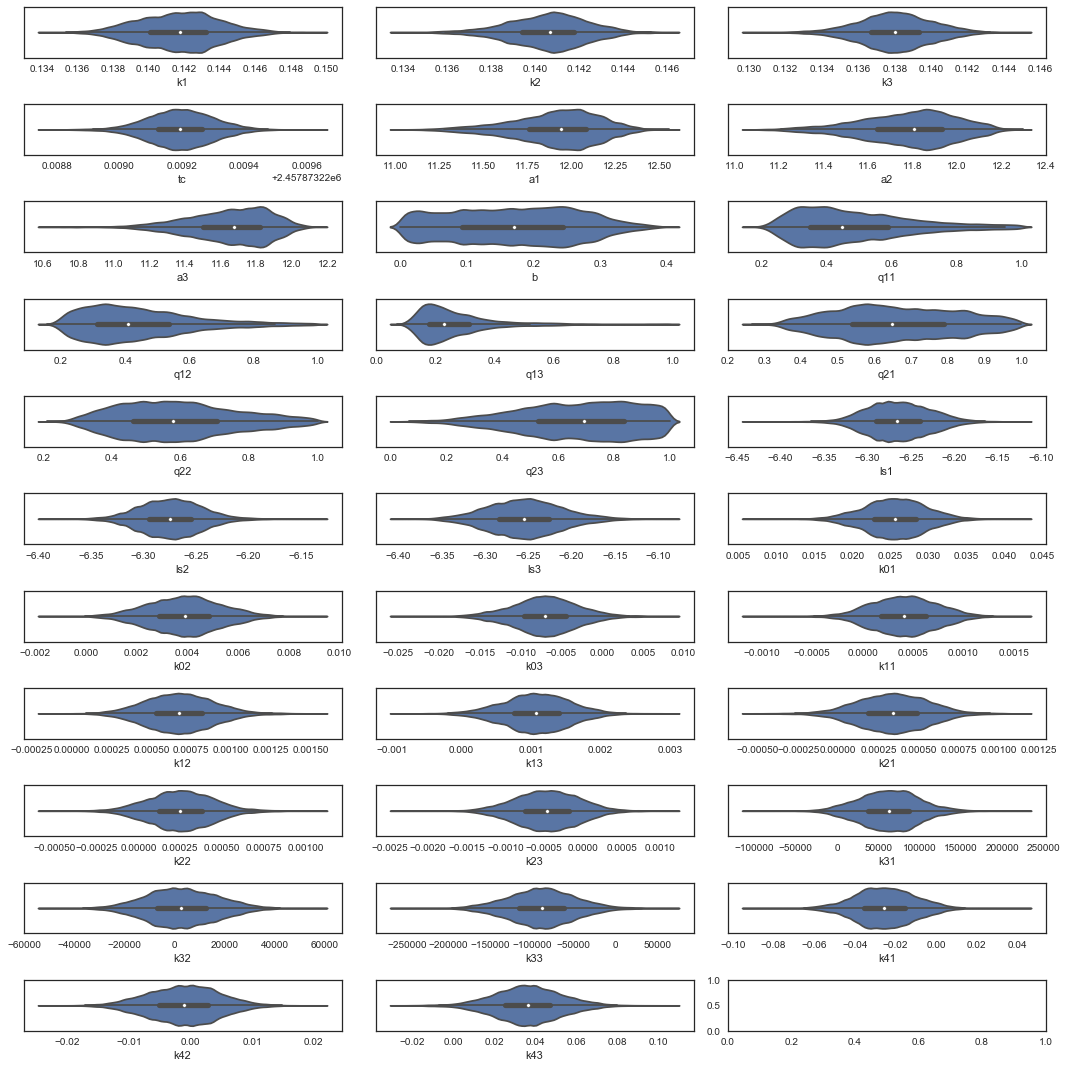

In [43]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = pl.subplots(11,3, figsize=(15,15))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    pl.setp(axs, ylabel='')
    fig.tight_layout()

## Sample the flatchain

In [49]:
#100 samples from the posterior for each band 
mod_sys={}
sys={}
mod={}

# theta1 = [k1,tc,a1,inc,u11,u21,ls1,k01,k11,k21,k31,k41]
# theta2 = [k2,tc,a2,inc,u12,u22,ls2,k02,k12,k22,k32,k42]
# theta3 = [k3,tc,a3,inc,u13,u23,ls3,k03,k13,k23,k33,k43]

col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

In [44]:
fig.savefig('figs/params_aposteriori_distributions.png')

In [50]:
[param_names[i] for i in col1]

['k1', 'tc', 'a1', 'b', 'q11', 'q21', 'ls1', 'k01', 'k11', 'k21', 'k31', 'k41']

$$
\rm \frac{no \; detection - expected \; value}{1\sigma \; bin} = 2.4 \; \sigma
$$

$$
P(\theta|D)\propto P(\theta) \times P(D|\theta) 
$$

In [51]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

#params varies per band
for b,t,f,am,xc,yc,col in zip(bands,
                             [t1,t2,t3],
                             [f1,f2,f3],
                             [airmass1,airmass2,airmass3],
                             #[unc1,unc2,unc3],
                             [xcen1,xcen2,xcen3],
                             [ycen1,ycen2,ycen3],
                            [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    
    aux_vec = [am, xc, yc]
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        for c in col:
            cc.append(th[c])
            
        mod_sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_full=True))
        sys[b].append(loglike(cc, t, f, _P, aux_vec, ret_sys=True))
        mod[b].append(loglike(cc, t, f, _P, aux_vec, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, t, f, _P, aux_vec, ret_mod=True)
    sys_best[b] = loglike(vv, t, f, _P, aux_vec, ret_sys=True)
    full_best[b] = loglike(vv, t, f, _P, aux_vec, ret_full=True)

check mean distribution for n samples sampled m times

### transit model

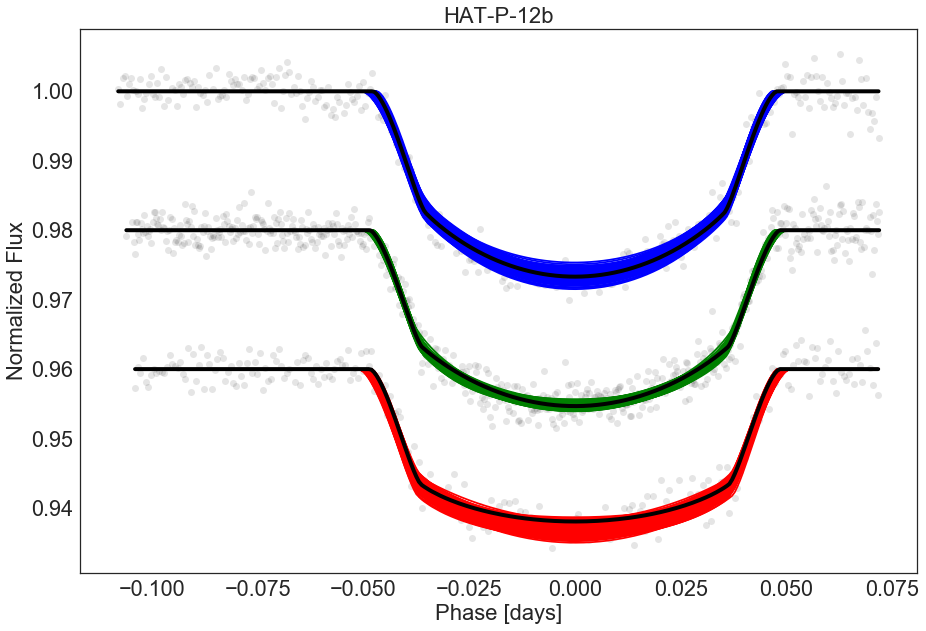

In [52]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=pl.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(ts[n]-tc_hat, fluxes[n]-sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(ts[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('HAT-P-12b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

How to define 1-sigma uncertainty? 
* from sampler.flatlnprobability
* from each parameter aposteriori (i pick this)

### systematics model

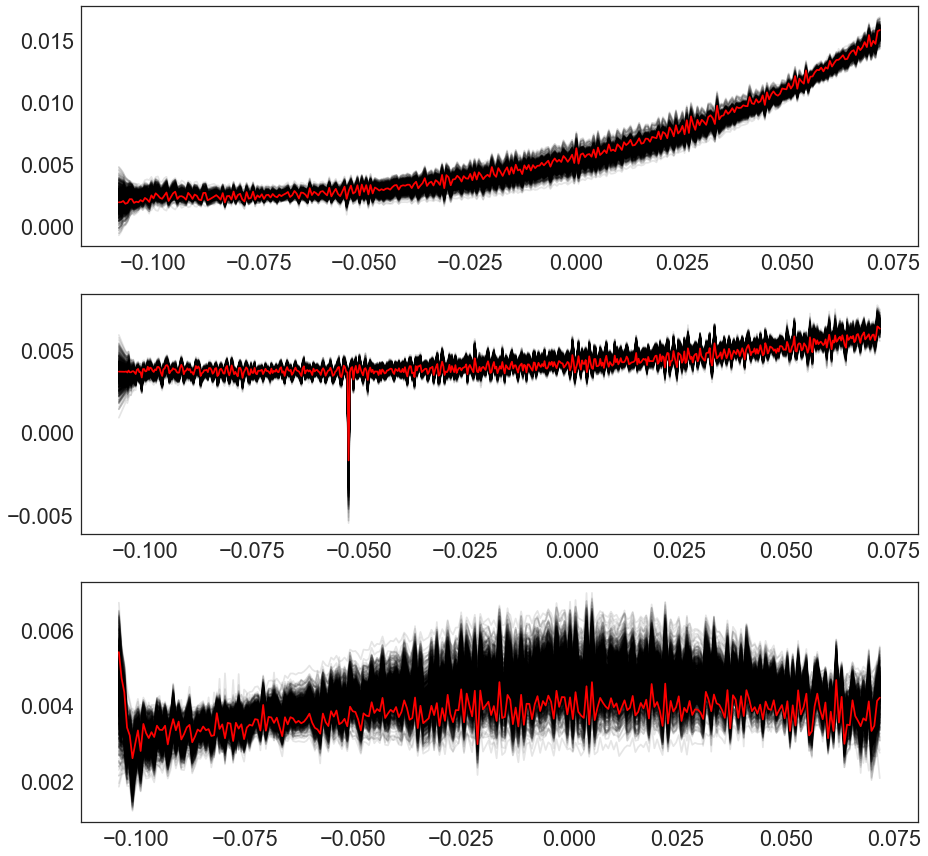

In [54]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-',alpha=0.1)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, sys_best[b], 'r-')

### systematics + transit

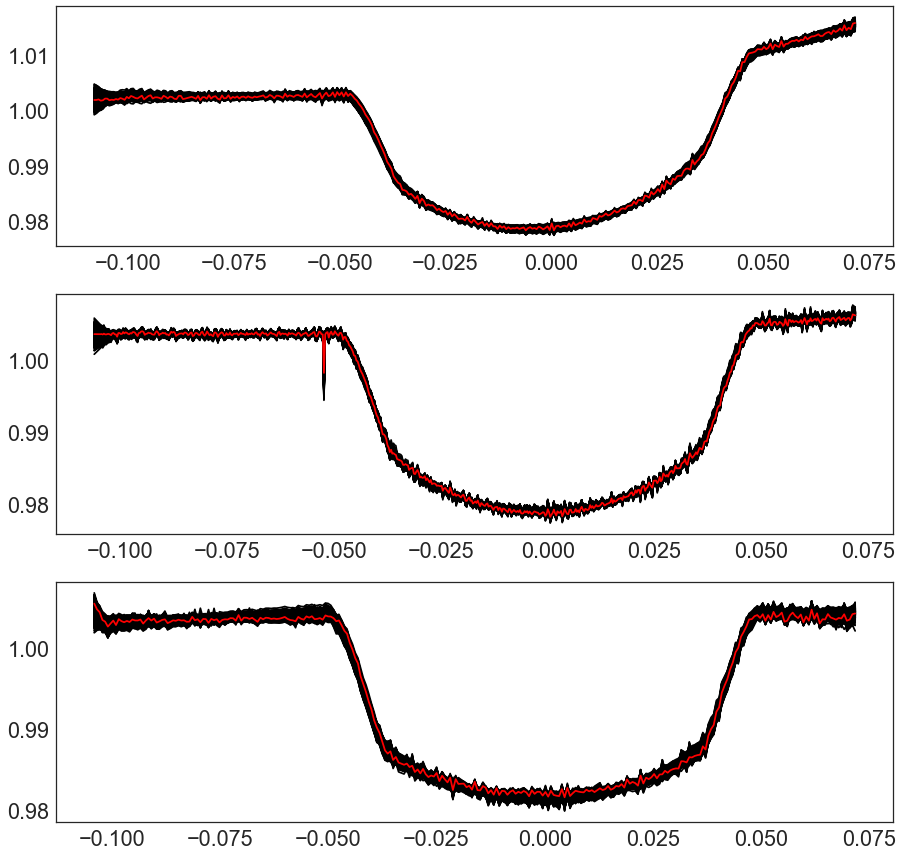

In [56]:
tc_hat=pv[3]
fig = pl.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    for i in mod_sys[b]:
        pl.plot(ts[n]-tc_hat, i,'k-')
    #superpose best fit
    ax.plot(ts[n]-tc_hat, full_best[b], 'r-')

## rms of residuals

In [62]:
def rms(x):
    return np.sqrt(np.nanmean(x**2))

In [63]:
thinning=10
for n,b in enumerate(bands):
    print(b)
    print('rms={}'.format(rms(fluxes[n]-sys_best[b]-mod_best[b])*100))

g
rms=0.1899453818384393
r
rms=0.18763372856835525
z
rms=0.1913572041052823


## binning
* See [stackoverflow](https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy)

The binning must be less than t14 and/or t34. Based on the best fit model on the detrended light curve, t14 is about 0.01 to 0.02 day.

## binning the residuals

Fukui-san's photometric precision achieved for HAT-P-14 (V=10):
```
g                       r                     z
RMS(10s)  = 0.10%       RMS(10s)  = 0.091%    RMS(30s) = 0.068%
RMS(5min) = 0.028%      RMS(5min) = 0.022%    RMS(5min) = 0.023%
```
$$
m_1-m_2=-2.5\log(f_1/f_2)\\
\rightarrow \frac{f_1}{f_2} = 10^{\Big(\frac{m_2-m_1}{2.5}\Big)}\\
\frac{f_1}{f_2} = 10^{\Big(\frac{13.2-10}{2.5}\Big)} = 19.9
$$
The photometric noise/ uncertainty goes with $\sqrt{\frac{f_1}{f_2}}$. Thus, the increase in the expected noise should be
$$
\sqrt{\frac{f_1}{f_2}}=4.47
$$
Currently, the rms of 0.23% for 5 minute binning, compared to Fukui-san's 0.028% is about an order of magnitude. I have to reduce this to about 5 to match the precisison achieved by Fukui-san.

## binning before model fitting

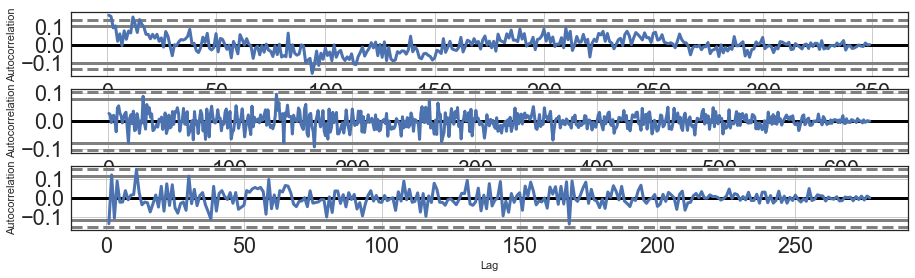

In [65]:
from pandas.plotting import autocorrelation_plot

fig = pl.figure(figsize=(15,4))
for n,b in enumerate(bands):
    ax=pl.subplot(3,1,n+1)
    autocorrelation_plot(fluxes[n]-sys_best[b]-mod_best[b], ax=ax)
    #autocorrelation_plot(sys_best[b]-mod_best[b], ax=ax)

In [66]:
fig.savefig('figs/autocorr.png')

correlation: u1, u2; k1, k3; i, a

In [67]:
n,b=0,'g'

d1 = {'g_flux': fluxes[n], 'g_mod': mod_best[b], 'g_sys':sys_best[b], 'g_full': full_best[b], 'g(f-sys)': fluxes[n]-sys_best[b]}
df1=pd.DataFrame(data=d1, index=ts[n])

n,b=1,'r'
d2 = {'r_flux': fluxes[n], 'r_mod': mod_best[b], 'r_sys':sys_best[b], 'r_full': full_best[b], 'r(f-sys)': fluxes[n]-sys_best[b]}
df2=pd.DataFrame(data=d2, index=ts[n])


n,b=2,'z'
d3 = {'z_flux': fluxes[n], 'z_mod': mod_best[b], 'z_sys':sys_best[b], 'z_full': full_best[b], 'z(f-sys)': fluxes[n]-sys_best[b]}
df3=pd.DataFrame(data=d3, index=ts[n])

frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

,g(f-sys),g_flux,g_full,g_mod,g_sys,r(f-sys),r_flux,r_full,r_mod,r_sys,z(f-sys),z_flux,z_full,z_mod,z_sys
GJD,,,,,,,,,,,,,,,
2.4579e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0026,1.0068,1.0041,1.0,0.0041
2.4579e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0001,1.0034,1.0033,1.0,0.0033
2.4579e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9977,1.0011,1.0035,1.0,0.0035
2.4579e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0038,1.0079,1.0041,1.0,0.0041
2.4579e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9963,1.0005,1.0042,1.0,0.0042


## Save

In [68]:
final_df.to_csv('after_mcmc_hatp12b.csv')

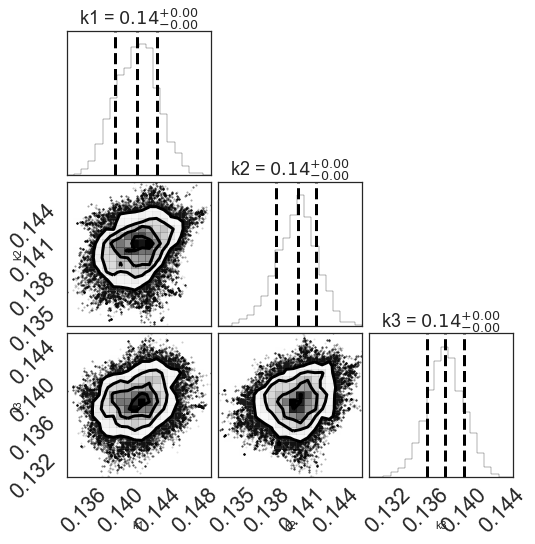

In [69]:
import corner


fig = corner.corner(fc[:,:3], labels=param_names[:3], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [70]:
fig.savefig('figs/joint_k.png')

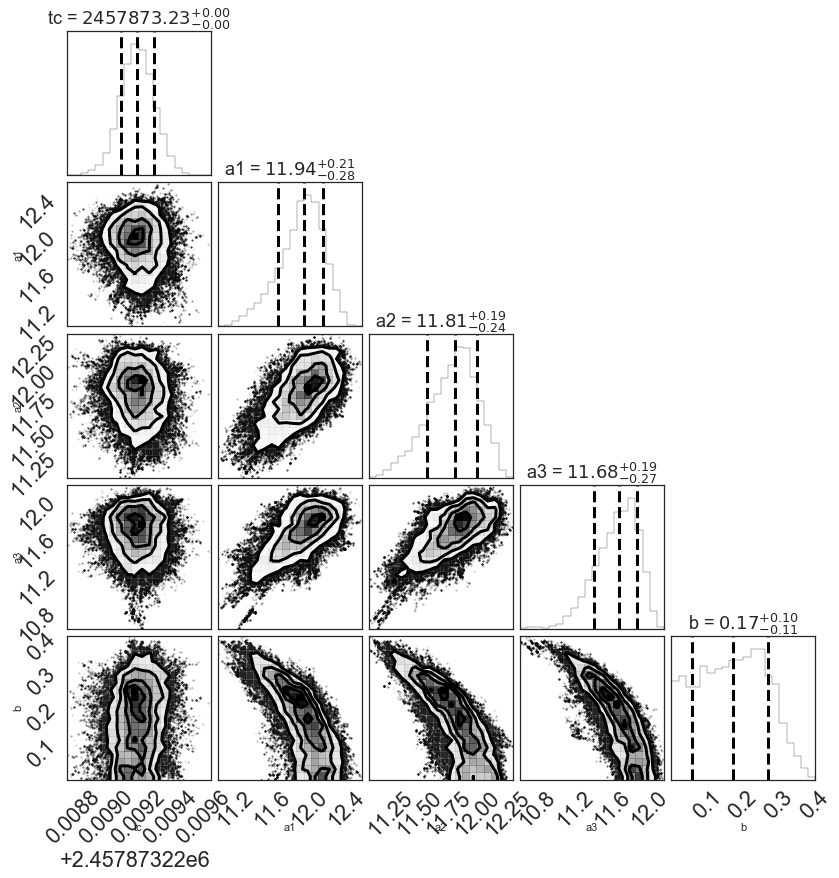

In [71]:
fig = corner.corner(fc[:,3:8], labels=param_names[3:8], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [72]:
fig.savefig('figs/joint_tc_a_b.png')

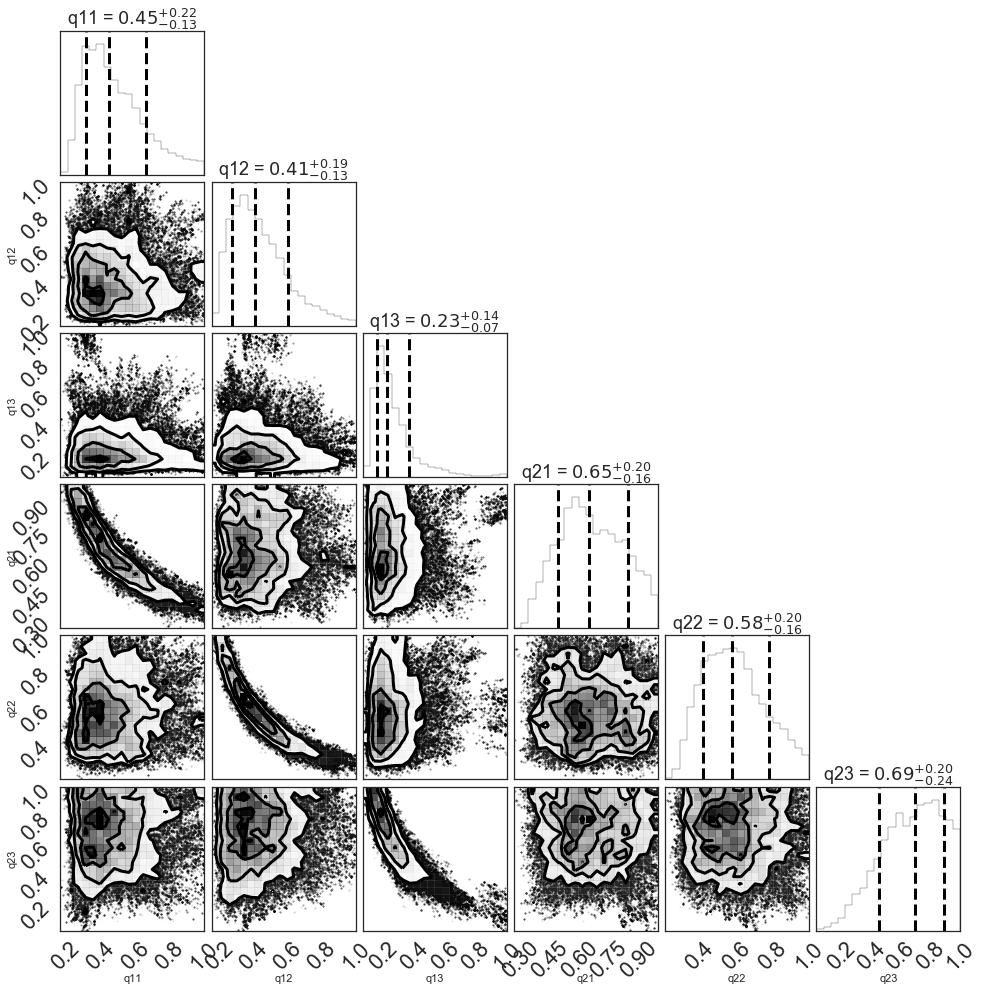

In [73]:
fig = corner.corner(fc[:,8:14], labels=param_names[8:14], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [74]:
fig.savefig('figs/q.png')

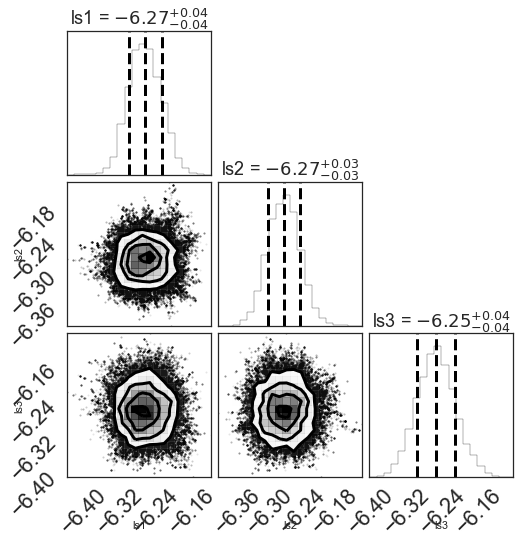

In [75]:
fig = corner.corner(fc[:,14:17], labels=param_names[14:17], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [77]:
fig = corner.corner(fc[:,17:], labels=param_names[17:], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## even sampling of time (index)

Add evenly sampled time to compensate for sparse data (resulting to edgy/not smooth model fits especially in limb-darkening areas.

### Reevaluate model using new evenly-sampled time

# Import mcmc results

In [80]:
pv[3]

2457873.2292884253

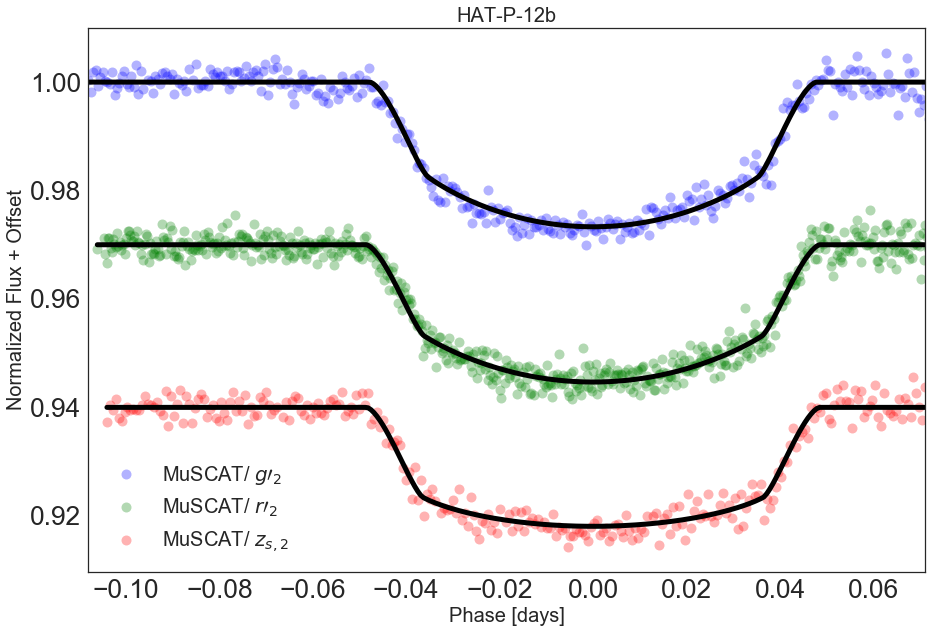

In [82]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

final_df=pd.read_csv('after_mcmc_hatp12b.csv', parse_dates=True, index_col=0)

tc=pv[3]

final_df.index=final_df.index-tc
fig,ax=pl.subplots(1,1,figsize=(15,10))
cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.03
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('HAT-P-12b', fontsize=fontsize)
ax.legend(labels,loc='lower left', fontsize=fontsize)

In [83]:
fig.savefig('figs/grz.png')

## Best fit models and (binned) residuals
* binning3 function is not implemented because of NaNs; df.resample is better because it takes into account the actual time and not only the separation between data points (e.g. two consecutive data points might be NaN and it can be problematic after binning). 
* See `width` to check binning width in min

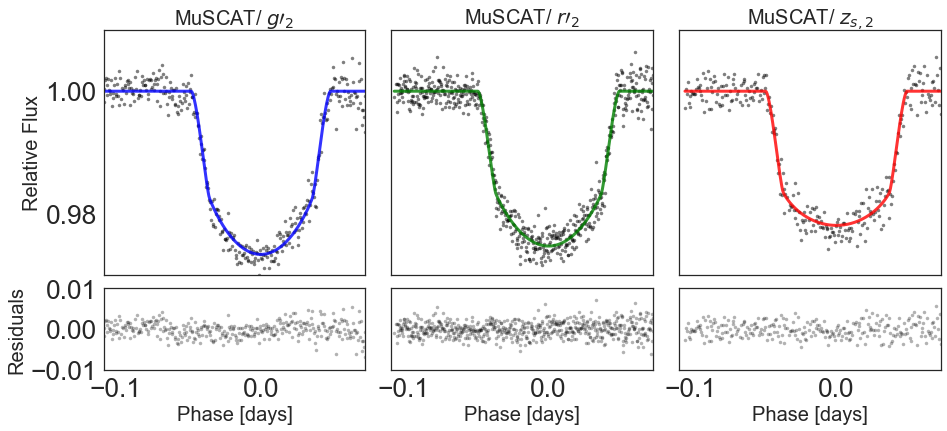

In [84]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 3})
from scipy import stats

final_df=pd.read_csv('after_mcmc_hatp12b.csv', parse_dates=True, index_col=0)
#final_df = df.set_index(pd.to_datetime(df.index, unit='D', origin=offset))

from matplotlib import gridspec

fig = pl.figure(figsize=(15,8))

gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[3, 1, 1],
                       wspace=0.1, 
                       hspace=0.1
                       )
clip=False
binn=False
clipped=20
binning='3T'
ylims= [0.97,1.01]
ylims2= [-0.01,0.01]

tc=2457873.2292264136
final_df.index=final_df.index-tc

ax1 = pl.subplot(gs[0])
if clip==True:
    final_df.iloc[:-clipped]['g(f-sys)'].plot(marker='.',alpha=0.5, 
                                            linestyle='', color='k', ax=ax1)
elif binn==True:
    final_df['g(f-sys)'].resample(binning).mean().plot(marker='.', 
                                alpha=0.1, linestyle='-', color=colors[0], ax=ax1)
else:
    final_df['g(f-sys)'].plot(marker='.', 
                                alpha=0.5, linestyle='', color='k', ax=ax1)
final_df['g_mod'].plot(linestyle='-',alpha=0.8, color=colors[0], ax=ax1)

ax1.set_ylim(ylims)
ax1.set_title(r'MuSCAT/ $g\prime_2$',fontsize=fontsize)
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux',fontsize=fontsize)
ax1.set_xlabel('')

ax2 = pl.subplot(gs[1])

if clip==True:
    final_df.iloc[:-clipped]['r(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[1], ax=ax2)
elif binn==True:
    final_df['r(f-sys)'].resample(binning).mean().plot(
        marker='.', alpha=0.1, linestyle='-', color=colors[1], ax=ax2)
else:
    final_df['r(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax2)
final_df['r_mod'].plot(alpha=0.8, linestyle='-', color=colors[1], ax=ax2)

ax2.set_ylim(ylims)
ax2.set_title(r'MuSCAT/ $r\prime_2$',fontsize=fontsize)
#ax2.axis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('')

ax3 = pl.subplot(gs[2])

if clip==True: #dropna, clip
    final_df.iloc[:-clipped]['z(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[2], ax=ax3)
elif binn==True: #bin
    final_df['z(f-sys)'].resample(binning).mean().plot(
        marker='.', ls='', alpha=0.1, linestyle='-', color=colors[2], ax=ax3)
else:
    final_df['z(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax3)
final_df['z_mod'].plot(linestyle='-', alpha=0.8, color=colors[2], ax=ax3)
    
ax3.set_ylim(ylims)
ax3.set_title(r'MuSCAT/ $z_{s,2}$',fontsize=fontsize)
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.set_yticklabels([])

ax4 = pl.subplot(gs[3])
diff_g=final_df['g(f-sys)']-final_df['g_mod']
diff_g.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax4)
#diff_g.resample(binning).mean().plot(marker='.', ax=ax4)

# t_bin=binning3(ts[0],bins=n_min_binning['g'])
# res_bin=binning3(diff_g.values,bins=n_min_binning['g'])
# ax4.plot(t_bin,res_bin,'bo')
ax4.set_ylabel('Residuals',fontsize=fontsize)
ax4.set_ylim(ylims2)
#ax4.set_xticklabels([])
ax4.set_xlabel('Phase [days]',fontsize=fontsize)

ax5 = pl.subplot(gs[4])
diff_r=final_df['r(f-sys)']-final_df['r_mod']
diff_r.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax5)
#diff_r.resample(binning).mean().plot(marker='.', ax=ax5)

# t_bin=binning3(ts[1],bins=n_min_binning['r'])
# res_bin=binning3(diff_r.values,bins=n_min_binning['r'])
# ax5.plot(t_bin,res_bin,'go')
ax5.set_ylim(ylims2)
#ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xlabel('Phase [days]',fontsize=fontsize)

ax6 = pl.subplot(gs[5])
diff_z=final_df['z(f-sys)']-final_df['z_mod']
diff_z.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax6)
#fit
slope, intercept, r_value, p_value, std_err = stats.linregress(diff_z.index-tc,diff_z)
y=slope*diff_z.index-tc+intercept
ax6.plot(diff_z.index,y,alpha=0.8, linestyle='-', color=colors[2])
#diff_z.resample(binning).mean().plot(marker='.', ax=ax6)

# t_bin=binning3(ts[2],bins=n_min_binning['z'])
# res_bin=binning3(diff_z.values,bins=n_min_binning['z'])
# ax6.plot(t_bin,res_bin,'bo')
ax6.set_ylim(ylims2)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xlabel('Phase [days]',fontsize=fontsize)

In [85]:
fig.savefig('figs/grz with rms.png')

## Comparison of k

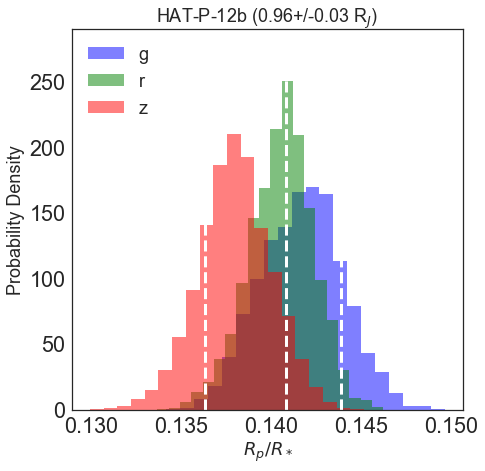

In [108]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

k_samples=[]
fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']

thin=1
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::thin,n]
    ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #show aposteriori value
    ax.vlines(pv[n], *ax.get_ylim(), linestyles='dashed', color='w')
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-12b ({:.2f} R$_J$)'.format(Rp), fontsize=18)
pl.legend(fontsize=fontsize)

In [87]:
fig.savefig('figs/radius ratios.png')

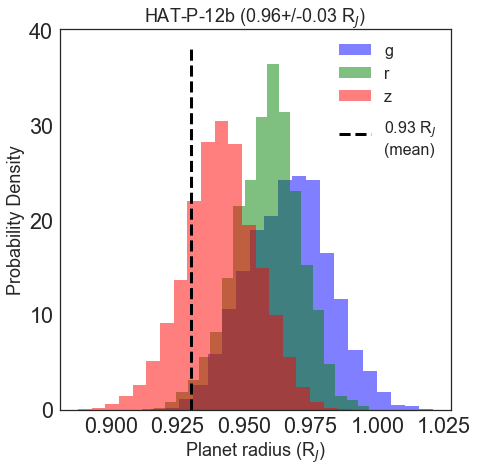

In [113]:
from astropy import units as u

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fontsize=18

Rs = ufloat(0.701,0.017) #0.017/-0.012
Rs = Rs.nominal_value

k_samples=[]

fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']

thin=1
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::thin,n]
    factor=Rs*u.solRad.to(u.Rjup)
    ax.hist(sampled*factor,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'Planet radius (R$_J$)',fontsize=fontsize)
    ax.set_ylabel('Probability Density',fontsize=fontsize)
#show mean of aposteriori values
mean=np.mean(pv[n]*factor)
pl.vlines(mean, *ax.get_ylim(), 
          linestyles='dashed', color='k', label='{:.2f} R$_J$\n(mean)'.format(mean))
pl.title('HAT-P-12b ({:.2f} R$_J$)'.format(Rp),fontsize=fontsize)
pl.legend(fontsize=16)

In [104]:
Rp_ = np.mean(pv[:3])*factor
print('published value = {}\ncomputed \t= {}\ndifference\t= {}'.format(Rp,Rp_,Rp - Rp_))

published value = 0.959+/-0.029
computed 	= 0.957531651599224
difference	= 0.001+/-0.029


In [89]:
fig.savefig('figs/radius ratios Rjup.png')

In [90]:
sigma_g_minus,sigma_g_mean,sigma_g_plus= np.percentile(k_samples[0],[15.9,50,84.1])
sigma_z_minus,sigma_z_mean,sigma_z_plus= np.percentile(k_samples[2],[15.9,50,84.1])
#diff=sigma_g_mean-sigma_z_mean
diff=sigma_g_minus-sigma_z_plus

sig=np.sqrt(sigma_z_plus**2+sigma_g_minus**2)
print('sigma_rss={}'.format(sig))
print('diff={}'.format(diff))
print('sigma={}'.format(diff/sig))

sigma_rss=0.19753485877741153
diff=-0.0007254910131273551
sigma=-0.0036727239820737723


In [91]:
(sigma_g_plus-sigma_z_minus)/np.mean([np.std(k_samples[0]),np.std(k_samples[2])])

3.700185381171949

## transmission spectrum

* See also procedure of [Nikolov+2016](https://arxiv.org/pdf/1610.01186.pdf)

In [92]:
for n in range(3):
    print(np.percentile(fc[::10,n],[50,16,84]))

[ 0.14177703  0.13933058  0.14394585]
[ 0.14067147  0.13878014  0.14227386]
[ 0.13799982  0.13606422  0.14003048]


In [93]:
pv[:3]

array([ 0.14390808,  0.14085565,  0.13634265])

* blue (g'2 : 400-550nm)
* red (r'2 : 550-700nm)
* NIR (zs,2 : 820-920nm)
* rp/rs=0.1343 (i-band)

slope=-0.000004


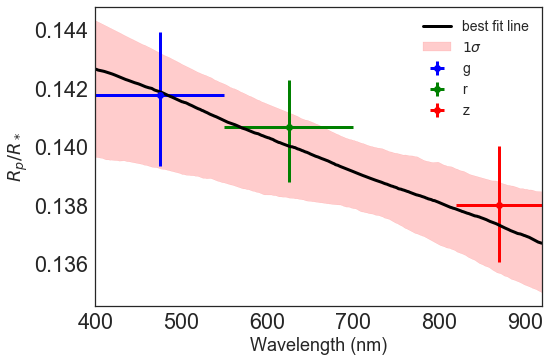

In [94]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

#bandwidths
xs1=[400,550,820]
xs2=[550,700,920]
#mean of each band
xmean=np.mean([xs1,xs2],axis=0)
ys=[]

#plot max aposteriori
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84],axis=0)
    ys.append(y)
    
#fit a line to k1,k2,k3
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
#ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'k-')

#sample and fit slopes and intercepts from the posterior
n = 10000
x = xmean
xi = np.linspace(400, 920, 500)
ys = []
lines = []
for i in range(n):
    y = fc[i,:3]
    slope,intercept,rvalue,pvalue,stderr = lg(xmean,y)
    line = slope * xi + intercept
    lines.append(line)
    
lo, hi, mid = np.percentile(lines, [16, 84, 50], axis=0)
ax.fill_between(xi, lo, hi, color='r', alpha=0.2, label='$1\sigma$')
ax.plot(xi,mid,'k-',label='best fit line')

# plot each sample
# for slop,interc in zip(slopes,intercepts):
#     ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)

#
bands='g,r,z'.split(',')
new_axis=[]
for n,(x,c,b) in enumerate(zip(xmean,colors,bands)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c, label=b) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)
ax.set_xlim(400,920)
ax.legend(fontsize=14)

print('slope={:.6f}'.format(slope))

In [95]:
fig.savefig('figs/spectrum')

## significance of detection

In [96]:
slopes=[]
intercepts=[]
nsamples=1000

s1=k_samples[0][np.random.randint(0, k_samples[0].shape[0], size=nsamples)]
s2=k_samples[1][np.random.randint(0, k_samples[1].shape[0], size=nsamples)]
s3=k_samples[2][np.random.randint(0, k_samples[2].shape[0], size=nsamples)]

for ss1,ss2,ss3 in zip(s1,s2,s3): 
    slope,intercept,_,_,_=lg(xmean,[ss1,ss2,ss3])
    slopes.append(slope)
    intercepts.append(intercept)

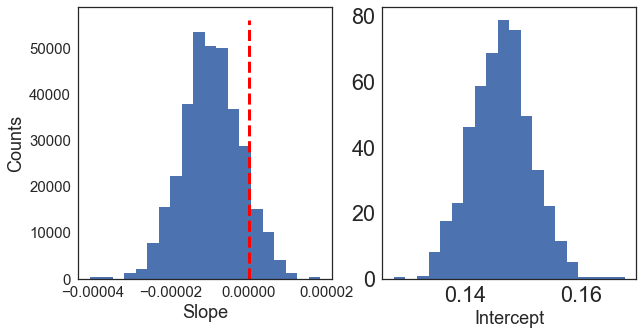

In [100]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
ax[0].hist(slopes,bins=20,normed=True);
ax[0].vlines(0, *ax[0].get_ylim(), color='r', linestyle='dashed')
ax[0].set_ylabel('Counts',fontsize=fontsize)
ax[0].set_xlabel('Slope',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].hist(intercepts,bins=20,normed=True);
ax[1].set_xlabel('Intercept',fontsize=fontsize)

In [101]:
fig.savefig('figs/slope.png')

From the posterior distribution of radius ratios, we took 1000 random samples each and computed the slope of the transmission spectrum (positioned at the center of the broadband filters). The histogram of the slope is shown in Fig. X consistent with negative values with 2.3 sigma.

In [98]:
x1,x2,x3=np.percentile(slopes,[50,15.9,84.1])
sig_plus=x3-x1
print((0-x1)/sig_plus)

1.25259744888


In [99]:
(pv[0]-pv[1])*Rs

0.0021397554408410808